In [1]:
import warnings

import arviz as az
import numpy as np
import pandas as pd
import pymc3 as pm

print(f"Running on PyMC3 v{pm.__version__}")
warnings.simplefilter(action="ignore", category=FutureWarning)
RANDOM_SEED = 8924
np.random.seed(286)

Running on PyMC3 v3.11.5


In [2]:
az.style.use("arviz-darkgrid")
# Import radon data
srrs2 = pd.read_csv(pm.get_data("srrs2.dat"))
srrs2.columns = srrs2.columns.map(str.strip)
srrs_mn = srrs2[srrs2.state == "MN"].copy()

In [3]:
srrs_mn["fips"] = srrs_mn.stfips * 1000 + srrs_mn.cntyfips
cty = pd.read_csv(pm.get_data("cty.dat"))
cty_mn = cty[cty.st == "MN"].copy()
cty_mn["fips"] = 1000 * cty_mn.stfips + cty_mn.ctfips

In [4]:
srrs_mn = srrs_mn.merge(cty_mn[["fips", "Uppm"]], on="fips")
srrs_mn = srrs_mn.drop_duplicates(subset="idnum")
u = np.log(srrs_mn.Uppm).unique()

n = len(srrs_mn)

In [5]:
srrs_mn.head()


,idnum,state,state2,stfips,zip,region,typebldg,floor,room,basement,...,stopdt,activity,pcterr,adjwt,dupflag,zipflag,cntyfips,county,fips,Uppm
0,5081,MN,MN,27,55735,5,1,1,3,N,...,12288,2.2,9.7,1146.499190,1,0,1,AITKIN,27001,0.502054
1,5082,MN,MN,27,55748,5,1,0,4,Y,...,12088,2.2,14.5,471.366223,0,0,1,AITKIN,27001,0.502054
2,5083,MN,MN,27,55748,5,1,0,4,Y,...,21188,2.9,9.6,433.316718,0,0,1,AITKIN,27001,0.502054
3,5084,MN,MN,27,56469,5,1,0,4,Y,...,123187,1.0,24.3,461.623670,0,0,1,AITKIN,27001,0.502054
4,5085,MN,MN,27,55011,3,1,0,4,Y,...,13088,3.1,13.8,433.316718,0,0,3,ANOKA,27003,0.428565


In [6]:
srrs_mn.county = srrs_mn.county.map(str.strip)
mn_counties = srrs_mn.county.unique()
counties = len(mn_counties)
county_lookup = dict(zip(mn_counties, range(counties)))

In [7]:
county = srrs_mn["county_code"] = srrs_mn.county.replace(county_lookup).values
radon = srrs_mn.activity
srrs_mn["log_radon"] = log_radon = np.log(radon + 0.1).values
floor = srrs_mn.floor.values

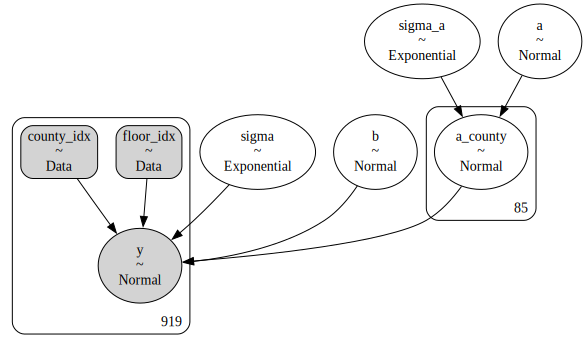

In [21]:
coords = {"Level": ["Basement", "Floor"], "obs_id": np.arange(floor.size)}
coords["County"] = mn_counties

with pm.Model(coords=coords) as partial_pooling:
    county_idx = pm.Data("county_idx", county, dims="obs_id")
    # Hyperpriors:
    a = pm.Normal("a", mu=0.0, sigma=10.0)
    sigma_a = pm.Exponential("sigma_a", 1.0)

    # Varying intercepts:
    a_county = pm.Normal("a_county", mu=a, sigma=sigma_a, dims="County")

    # Expected value per county:
    theta = a_county[county_idx]
    # Model error:
    sigma = pm.Exponential("sigma", 1.0)

    y = pm.Normal("y", theta, sigma=sigma, observed=log_radon, dims="obs_id")
# pm.model_to_graphviz(partial_pooling)

with pm.Model(coords=coords) as varying_intercept:
    floor_idx = pm.Data("floor_idx", floor, dims="obs_id")
    county_idx = pm.Data("county_idx", county, dims="obs_id")
    # Hyperpriors:
    a = pm.Normal("a", mu=0.0, sigma=10.0)
    sigma_a = pm.Exponential("sigma_a", 1.0)

    # Varying intercepts:
    a_county = pm.Normal("a_county", mu=a, sigma=sigma_a, dims="County")
    # Common slope:
    b = pm.Normal("b", mu=0.0, sigma=10.0)

    # Expected value per county:
    theta = a_county[county_idx] + b * floor_idx
    # Model error:
    sigma = pm.Exponential("sigma", 1.0)

    y = pm.Normal("y", theta, sigma=sigma, observed=log_radon, dims="obs_id")
pm.model_to_graphviz(varying_intercept)

In [14]:
with varying_intercept:
    varying_intercept_idata = pm.sample(
        tune=2000, init="adapt_diag", random_seed=RANDOM_SEED, return_inferencedata=True
    )

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b, a_county, sigma_a, a]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 28 seconds.
The number of effective samples is smaller than 25% for some parameters.


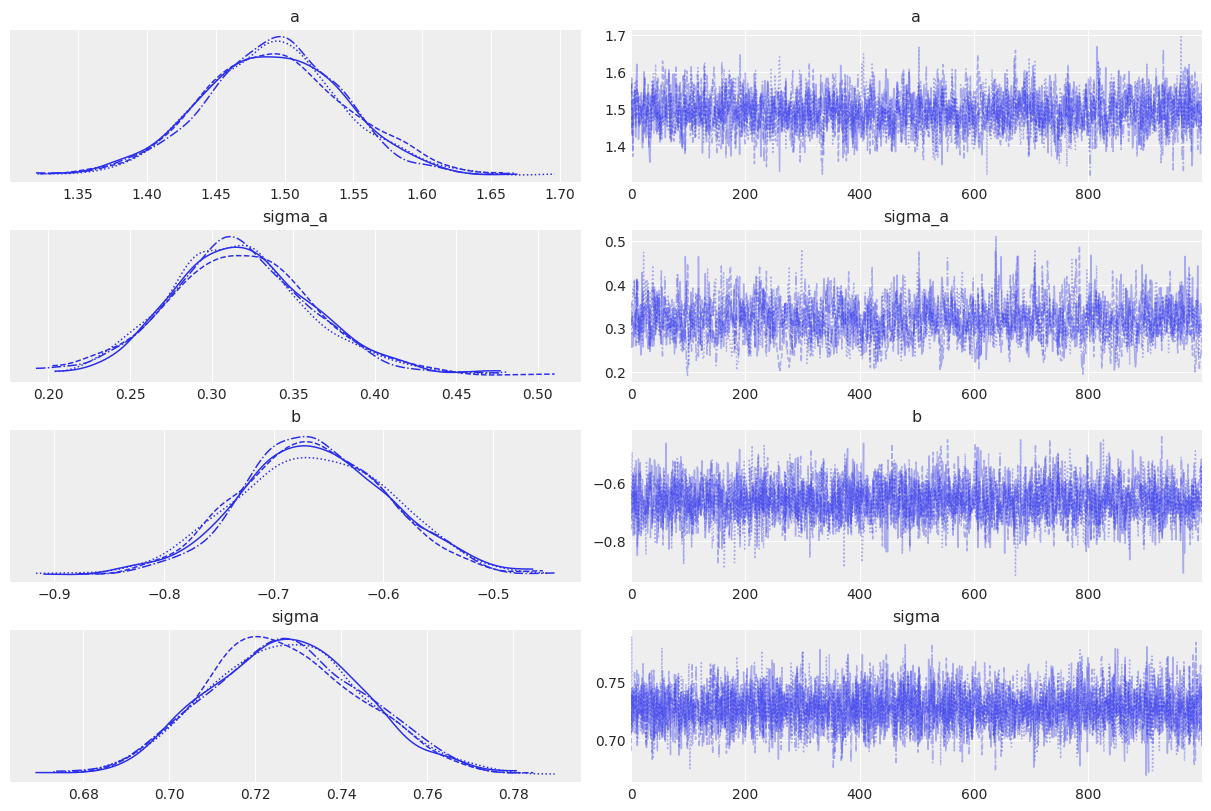

In [15]:
az.plot_trace(varying_intercept_idata, var_names=["a", "sigma_a", "b", "sigma"]);

In [18]:
import statsmodels.formula.api as smf

results_lme = smf.mixedlm('log_radon ~ floor', data=srrs_mn, groups=srrs_mn['county_code']).fit()


In [20]:
results_lme.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
         Mixed Linear Model Regression Results
========================================================
Model:            MixedLM Dependent Variable: log_radon 
No. Observations: 919     Method:             REML      
No. Groups:       85      Scale:              0.5268    
Min. group size:  1       Log-Likelihood:     -1048.7610
Max. group size:  116     Converged:          Yes       
Mean group size:  10.8                                  
--------------------------------------------------------
              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------
Intercept      1.492    0.050 29.931 0.000  1.395  1.590
floor         -0.663    0.068 -9.777 0.000 -0.796 -0.530
Group Var      0.099    0.039                           
========================================================

"""